# Connection to garmin connect with Garth

In [7]:
import garth
import os 
from garth.exc import GarthException
from typing import Dict, List, Tuple, Optional
from datetime import date, timedelta
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import json

In [2]:
GARMIN_EMAIL = os.getenv("EMAIL")
GARMIN_PASSWORD = os.getenv("PASSWORD")

GARTH_HOME = "~/.garth"

In [3]:
print(GARMIN_EMAIL)

lucas.piquet@centrale.centralelille.fr


Le scrip de requete à l'api de garmin se trouve ici:
https://github.com/matin/garth/blob/main/garth/http.py

In [3]:
try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (FileNotFoundError, GarthException):
    garth.login(GARMIN_EMAIL, GARMIN_PASSWORD)

garth.save(GARTH_HOME)

### Stress

In [13]:
garth.WeeklyStress.list()[0]

WeeklyStress(calendar_date=datetime.date(2025, 3, 13), value=27)

In [8]:
weekly_stress = garth.WeeklyStress.list(period=104)

#### Plot

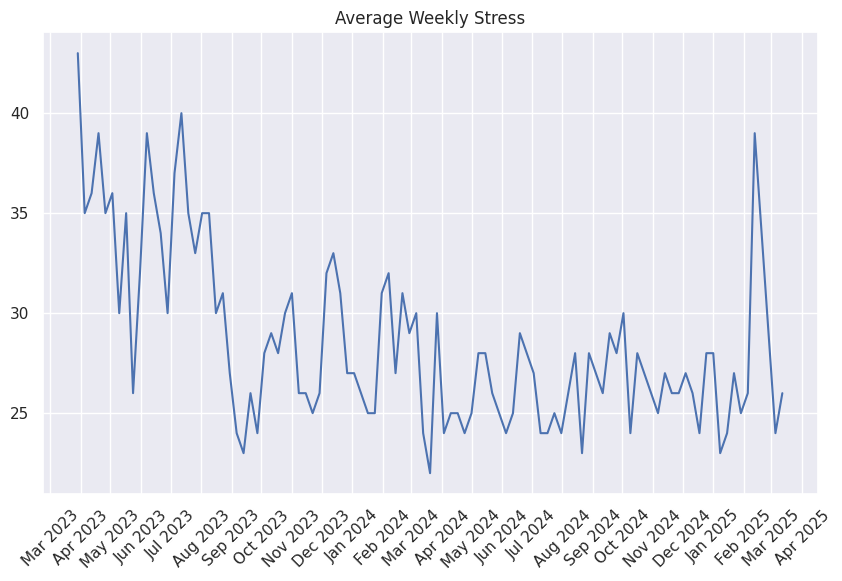

In [ ]:
df = pd.DataFrame(weekly_stress).sort_values("calendar_date")

sns.set_theme()

plt.figure(figsize=(10, 6))

sns.lineplot(x=df["calendar_date"], y=df["value"])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)

plt.xlabel(None)
plt.ylabel(None)
plt.title("Average Weekly Stress")

plt.show()

In [ ]:
garth.DailyStress.list(date.today() - timedelta(days=1))[0]

DailyStress(calendar_date=datetime.date(2025, 3, 17), overall_stress_level=24, rest_stress_duration=32520, low_stress_duration=12060, medium_stress_duration=240, high_stress_duration=None)

In [14]:
daily_stress = garth.DailyStress.list(period=365 * 3)

In [12]:
len((daily_stress))

692

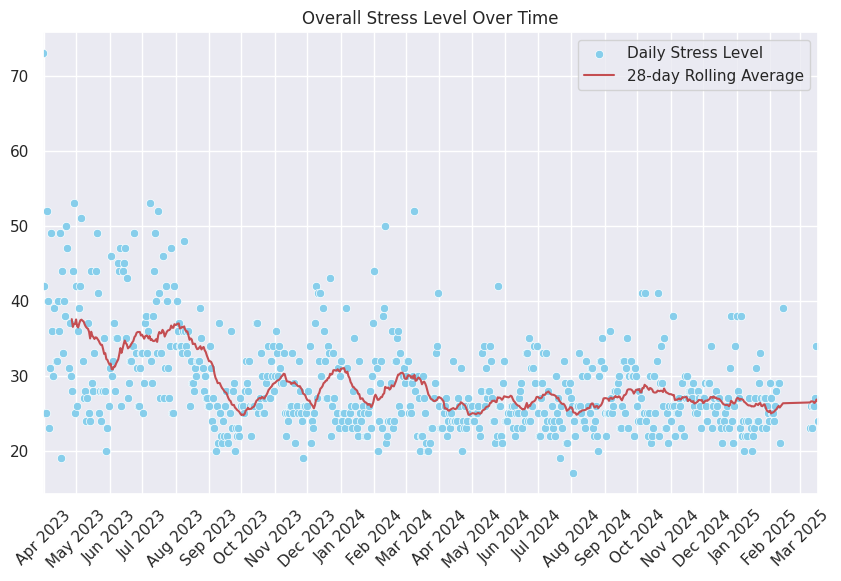

In [ ]:
# Plot stress overall
sns.set_theme()

df = pd.DataFrame(daily_stress)
df.set_index("calendar_date", inplace=True)

df["rolling_avg"] = df["overall_stress_level"].rolling(window=28).mean()

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df.index,
    y=df["overall_stress_level"],
    color="skyblue",
    label="Daily Stress Level"
)

sns.lineplot(
    x=df.index,
    y=df["rolling_avg"],
    color="r",
    label="28-day Rolling Average"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.xlim(df.index.min(), df.index.max())
plt.xlabel(None)
plt.ylabel(None)
plt.title("Overall Stress Level Over Time")
plt.legend()

plt.show()

In [26]:
# Plot overall stress


result = seasonal_decompose(
    df["overall_stress_level"], model="additive", period=28
)
trend = result.trend.dropna()

min_date = df.index.min()
max_date = df.index.max()

def plot_subplot(ax, x, y, title, color, plot_type="line"):
    if plot_type == "line":
        sns.lineplot(ax=ax, x=x, y=y, color=color)
    elif plot_type == 'scatter':
        sns.scatterplot(ax=ax, x=x, y=y, color=color)

    ax.set_title(title)
    ax.set_xlim(min_date, max_date)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

plot_subplot(
    axes[0], df.index, df["overall_stress_level"],
    "Daily Stress Level", "skyblue", plot_type='scatter'
)
plot_subplot(axes[1], trend.index, trend, "28-Day Trend", "r")

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

### Fetch Steps

Toutes les classes proviennet de la classe stats.

In [ ]:
# BASE_PATH = "/usersummary-service/stats/steps"

weekly_steps = garth.WeeklySteps.list(period=27)


In [6]:
garth.WeeklySteps.list(period=27)

[WeeklySteps(calendar_date=datetime.date(2024, 9, 13), total_steps=129206, average_steps=18458.0, average_distance=17512.571428571428, total_distance=122588.0, wellness_data_days_count=7),
 WeeklySteps(calendar_date=datetime.date(2024, 9, 20), total_steps=128383, average_steps=18340.428571428572, average_distance=17028.0, total_distance=119196.0, wellness_data_days_count=7),
 WeeklySteps(calendar_date=datetime.date(2024, 9, 27), total_steps=61678, average_steps=8811.142857142857, average_distance=7504.142857142857, total_distance=52529.0, wellness_data_days_count=7),
 WeeklySteps(calendar_date=datetime.date(2024, 10, 4), total_steps=109263, average_steps=15609.0, average_distance=13944.42857142857, total_distance=97611.0, wellness_data_days_count=7),
 WeeklySteps(calendar_date=datetime.date(2024, 10, 11), total_steps=104352, average_steps=14907.42857142857, average_distance=13630.857142857143, total_distance=95416.0, wellness_data_days_count=7),
 WeeklySteps(calendar_date=datetime.date

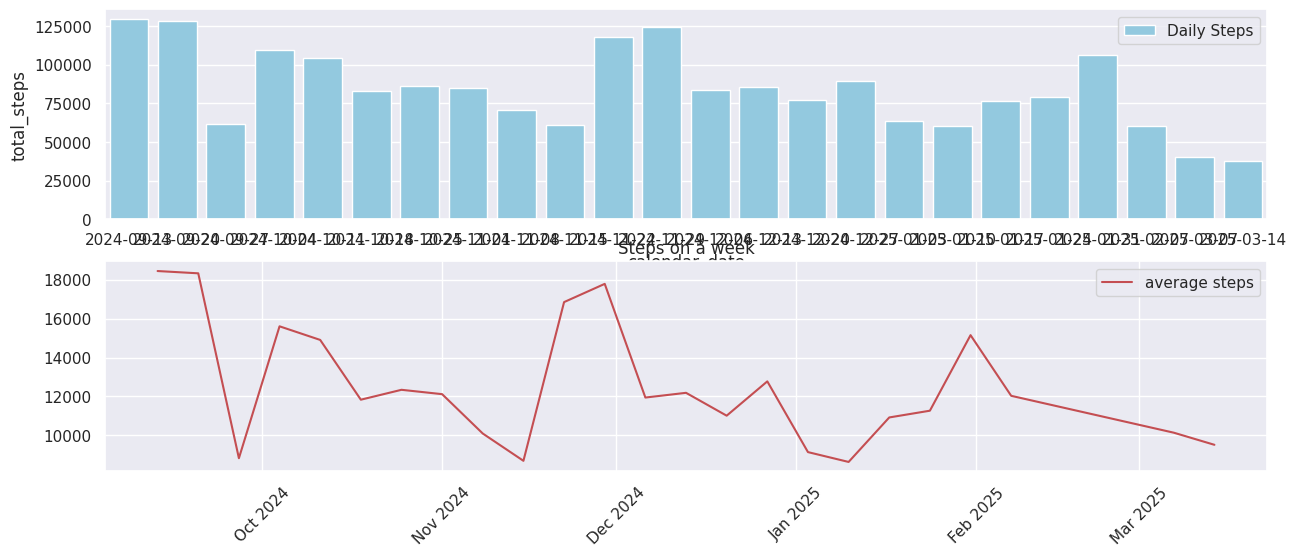

In [ ]:
# Plot daily step
sns.set_theme()

df = pd.DataFrame(weekly_steps)
df.set_index("calendar_date", inplace=True)

df["rolling_avg"] = df["total_steps"].rolling(window=28).mean()

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

sns.barplot(
    ax=axes[0],
    x=df.index,
    y=df["total_steps"],
    color="skyblue",
    label="Daily Steps"
)

sns.lineplot(
    ax=axes[1],
    x=df.index,
    y=df["average_steps"],
    color="r",
    label="average steps"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
#plt.xlim(df.index.min(), df.index.max())
plt.xlabel(None)
plt.ylabel(None)
plt.title("Steps on a week")
plt.legend()

plt.show()

### HRV

Il n'y a pas de champ weekly hrv car la mesure n'est pas pertinente il me semble. 
Mais daily ne renvoi aucune donné sans doute la montre ne prend pas en charge cette mesure. 

In [ ]:
weekly_hrv= garth.DailyHRV.list(period=3)

In [15]:
print(weekly_hrv)

[]


### Fetch Sleep

La granularité des donnés de sommeil est à la minute

Les heures de réveils semblent cohérentes mais les heures de couchés sont trop tôt à voir comment il déclenche ces mesures de sommeils. 

In [ ]:
def datetime_to_string_d_m_y(date: datetime)->str:
    return date.strftime('%d/%m/%Y')
date_test = date.today() - timedelta(2)
print(datetime_to_string_d_m_y(date_test), date_test.isoformat())

In [4]:
yesterday = date.today() - timedelta(1)
yesterday = yesterday.isoformat()
yesterday

'2025-03-20'

In [5]:
weekly_sleep = garth.SleepData.list(yesterday, 10)

In [6]:
total_sleep: list[int] = []
for day in weekly_sleep:
    total_sleep.append(len(day.sleep_movement))

print(f'total for each night of the selected period in minutes : {total_sleep}')

min_tot = 693
print(f'equivelent in hours : {min_tot//60}h {min_tot%60}min')

total for each night of the selected period in minutes : [693, 712, 744, 695, 653, 775, 831, 678, 626]
equivelent in hours : 11h 33min


In [17]:
movement_record: List[Dict[str,str|int]]= []
for movement_idx, sleep_movement in enumerate(weekly_sleep[0].sleep_movement):
    
    start_gmt: datetime = sleep_movement.start_gmt
    end_gmt: datetime = sleep_movement.end_gmt
    activity_level: int = sleep_movement.activity_level
    movement_record.append({"start_gmt":start_gmt.isoformat(),
    "end_gmt":end_gmt.isoformat(),
    "activity_level":activity_level
    })

    with open('sleep_test.json', "w") as f:

        json.dump(movement_record, f, indent = 4)

### Create a dataframe

In [ ]:
starts_gmt: List[str]= []
ends_gmt: List[str]= []
activity_levels: List[int]= []

for movement_idx, sleep_movement in enumerate(weekly_sleep[0].sleep_movement):
    
    starts_gmt.append(sleep_movement.start_gmt.isoformat())
    ends_gmt.append(sleep_movement.end_gmt.isoformat())
    activity_levels.append(sleep_movement.activity_level)


with open('sleep_test2.json', "w") as f:

    dict_movements: Dict[str,List[str]|List[int]] = {"starts_gmt":starts_gmt,
                                                    "ends_gmt":ends_gmt,
                                                    "activity_levels":activity_levels
                                                    }

    json.dump(dict_movements, f, indent = 4, default=str)
    


In [33]:
df_sleep:pd.DataFrame = pd.DataFrame({"starts_gmt":[datetime.fromisoformat(start_gmt) for start_gmt in starts_gmt],
                                    "ends_gmt":[datetime.fromisoformat(end_gmt) for end_gmt in ends_gmt],
                                    "activity_levels":activity_levels
                                    })
df_sleep.head()

,starts_gmt,ends_gmt,activity_levels
0,2025-03-10 21:49:00,2025-03-10 21:50:00,5.514703
1,2025-03-10 21:50:00,2025-03-10 21:51:00,5.029194
2,2025-03-10 21:51:00,2025-03-10 21:52:00,4.519621
3,2025-03-10 21:52:00,2025-03-10 21:53:00,3.995051
4,2025-03-10 21:53:00,2025-03-10 21:54:00,3.458353


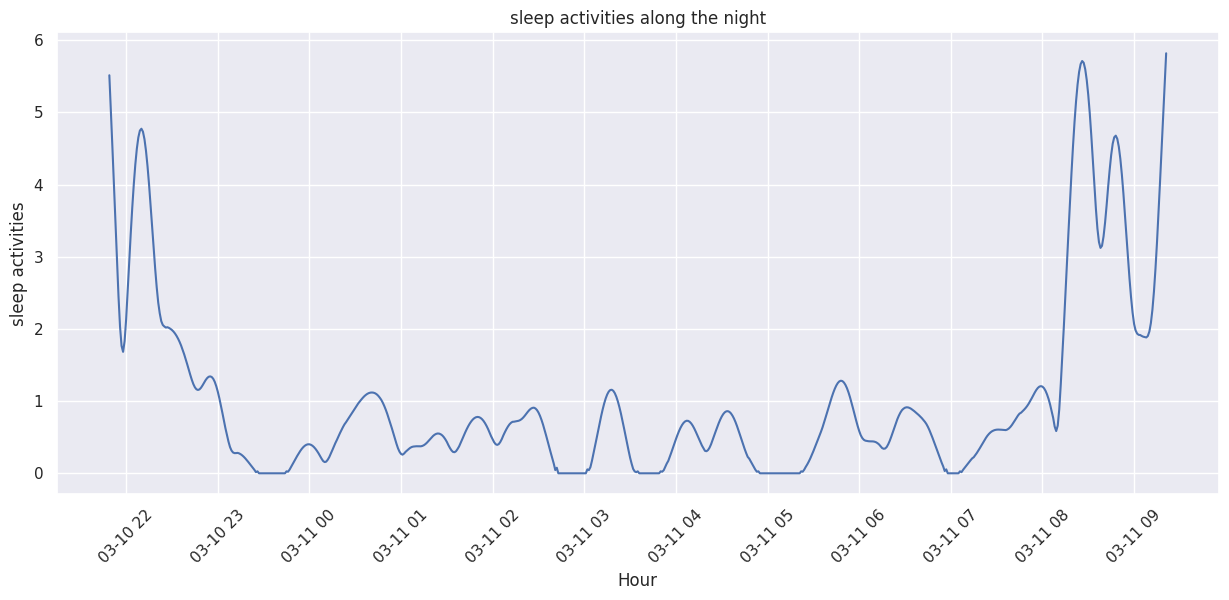

In [35]:
sns.set_theme()

plt.figure(figsize=(15,6))

sns.lineplot(x=df_sleep["starts_gmt"],y=df_sleep["activity_levels"])

plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.HourLocator()))

plt.xticks(rotation=45)

plt.xlabel("Hour")
plt.ylabel("sleep activities")
plt.title("sleep activities along the night")

plt.show()


### Create a dataframe

In [ ]:
calendar_dates: List[datetime]= []
sleep_times_seconds: List[int]= []
sleep_starts_timestamp_local: List[int]= []
sleep_scores: List[Optional[int]]= []

for day in weekly_sleep:

    daily_sleep_dto = day.daily_sleep_dto

    calendar_dates.append(daily_sleep_dto.calendar_date)
    sleep_times_seconds.append(daily_sleep_dto.sleep_time_seconds)
    sleep_starts_timestamp_local.append(daily_sleep_dto.sleep_start_timestamp_gmt)
    sleep_scores.append(daily_sleep_dto.sleep_scores)


sleep_file: Dict[str,List[datetime]| List[int]] = {
    "calendar_date": calendar_dates,
    "sleep_time_seconds": sleep_times_seconds,
    "sleep_start_timestamp_local": sleep_starts_timestamp_local,
    "sleep_scores": sleep_scores
}
df_sleep_meta: pd.DataFrame = pd.DataFrame(sleep_file)

df_sleep_meta.head()


,calendar_date,sleep_time_seconds,sleep_start_timestamp_local,sleep_scores
0,2025-03-11,34380,1741646940000,None
1,2025-03-12,35400,1741729560000,None
2,2025-03-13,37260,1741812600000,None
3,2025-03-14,34500,1741903320000,None
4,2025-03-15,31980,1741992480000,None


### Comparaison of the scripts the garth lib between sleep, intensive_min, stress, hrv, steps

In [ ]:
# Stress "/usersummary-service/stats/stress" f"{BASE_PATH}/daily/{{start}}/{{end}}"

# Steps "/usersummary-service/stats/steps" f"{BASE_PATH}/daily/{{start}}/{{end}}"

# HRV "/hrv-service/hrv/daily/{start}/{end}"

# Sleep "/wellness-service/stats/daily/sleep/score/{start}/{end}"

#

### Manual request to explore garmin API

In [22]:
configure = None
oauth1_token = None
oauth2_token = None
directory_path = os.path.expanduser(GARTH_HOME)

with open(os.path.join(directory_path, "oauth1_token.json"), "r") as f:
    oauth1_token = json.load(f)

with open(os.path.join(directory_path, "oauth2_token.json"), "r") as f:
    oauth2_token = json.load(f)


In [ ]:
from requests import Session
from requests.adapters import HTTPAdapter, Retry
from urllib.parse import urljoin


USER_AGENT = {"User-Agent": "GCM-iOS-5.7.2.1"}

# Créer une session
session = Session()
session.headers.update(USER_AGENT)
# session.proxies.update(proxies)

retry = Retry(
            total=3,
            status_forcelist=(408, 429, 500, 502, 503, 504),
            backoff_factor=0.5,
        )

adapter = HTTPAdapter(
            max_retries=retry,
            pool_connections=10,
            pool_maxsize=10,
        )

session.mount("https://", adapter)

# url = f"{self.garmin_connect_floors_chart_daily_url}/{cdate}"

yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.isoformat()

garmin_connect_floors_chart_daily_url = "/wellness-service/wellness/floorsChartData/daily"

path = f"{garmin_connect_floors_chart_daily_url}/{yesterday}"
url  = urljoin('https://connect_api.garmin.com/', path)
print(url)

# Envoyer une requête GET
response = session.request('GET', 'https://connect_api.garmin.com/', url, timeout=10)

# Afficher le code de statut et le contenu de la réponse
print(response.status_code)
print(response.text)


https://connect_api.garmin.com/wellness-service/wellness/floorsChartData/daily/2025-03-17


ConnectionError: HTTPSConnectionPool(host='connect_api.garmin.com', port=443): Max retries exceeded with url: /?https://connect_api.garmin.com/wellness-service/wellness/floorsChartData/daily/2025-03-17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c7f1efc6da0>: Failed to resolve 'connect_api.garmin.com' ([Errno -2] Name or service not known)"))

TO DO: I need authentification credits to connect to the API.

Pour le process d'autenfication. Les 2 librairies utilise garth le script sso. 

Quand garth.login ou garmin.login est appelé, derrière dans le script sso une première requete **get** permet de set up les cookies puis une seconde permet de récupérer le **token CSFR** puis une requete **post** contenant le token permet l'authentification. 